In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Assignment 7 Problem 2

### a)

In [2]:
## calculate B (see hand-written derivations)
B = (-1./(2.*np.log(2.)))
print(B)

-0.7213475204444817


In [3]:
def V1(i,j): # the function that has been derived for the unit charge
    if i == 0 and j == 0:
        return 1.
    return B/2.*np.log(i**2+j**2)

In [4]:
## sanity check:
V1(5,0)

-1.160964047443681

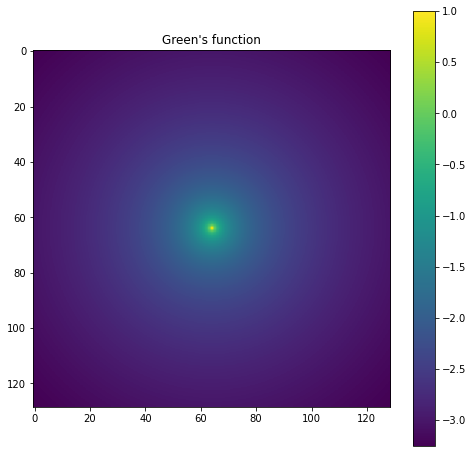

In [5]:
def makeG(n):  # create a Green's function matrix 
    x = np.arange(-n//2+1, n//2+1, 1)
    xx,yy=np.meshgrid(x,x)
    G = np.zeros(xx.shape)
    for row in range(-n//2+1,n//2+1):
        for col in range(-n//2+1,n//2+1):
            G[row,col]= V1(xx[row,col],yy[row,col])
    return G

G = makeG(129)

plt.figure(figsize = (8,8))
plt.imshow(G)
plt.colorbar()
plt.title("Green's function")
plt.show()

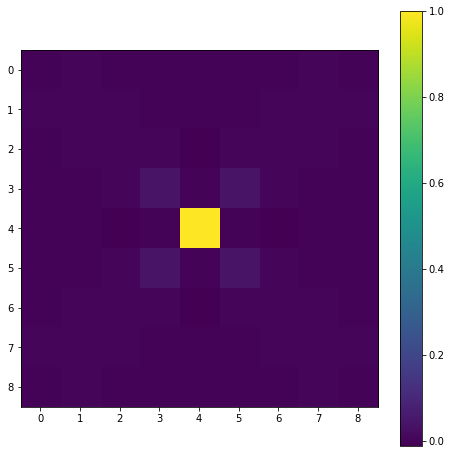

Total extra charge = 0.1331


In [6]:
### bonus
def apply_stencil(V):
    return V - 0.25*(np.roll(V,1,axis=0)+np.roll(V,-1,axis=0)+np.roll(V,1,axis=1)+np.roll(V,-1,axis=1))
inferred_rho = apply_stencil(G)
# cancel the edge effects:
inferred_rho[:,0] = 0.
inferred_rho[:,-1] = 0.
inferred_rho[0, :] = 0.
inferred_rho[-1,:] = 0.

extra_charge = inferred_rho.copy()
extra_charge[inferred_rho == 1.] = 0.

plt.figure(figsize = (8,8))
plt.imshow(inferred_rho[60:69, 60:69])
plt.colorbar()
plt.show()
print('Total extra charge =','%.4f'%(np.sum(extra_charge)))

In [7]:
# make corrections to G
Gcor = G.copy()
for k in range(10):
    extraV = np.real(np.fft.ifft2(np.fft.fft2(Gcor)*np.fft.fft2(extra_charge)))
    Gcor = Gcor - extraV
    extra_charge = apply_stencil(Gcor)
    extra_charge[inferred_rho == 1.] = 0.
    print('iteration', k, ', extra charge =', np.sum(extra_charge))

iteration 0 , extra charge = -1.0001444389115455
iteration 1 , extra charge = -1.0402269150813217
iteration 2 , extra charge = -1.1310105428164778
iteration 3 , extra charge = -1.3566468188404848
iteration 4 , extra charge = 0.22684406658845546
iteration 5 , extra charge = 165612.67396312952
iteration 6 , extra charge = 78762747871676.0
iteration 7 , extra charge = -1.3245774729196556e+32
iteration 8 , extra charge = 2.98100676602404e+67
iteration 9 , extra charge = 2.503203400084027e+139


#### doesn't work ??

### b)

In [8]:
## G conv rho = V  -> Ax = b, solve with CG
def Ax(rho, Gfft, mask):  # convolution here is analogous to LHS 
    R = np.fft.fft2(rho) ## fft of charge density
    res = np.real(np.fft.ifft2(Gfft*R))
    res = res*mask # we are solving only for the region where V = 1
    return res
      
n = 129
mask = np.zeros([n,n], dtype = 'bool')
mask[n//4:3*n//4,n//4:3*n//4] = True  # a box
V = np.zeros([n,n], dtype = float)
V[mask] = 1.
rho = np.zeros([n,n], dtype = float) # initial guess
G = makeG(n)
Gfft = np.fft.fft2(G)

##########################

b = V #RHS of the equation
r = b - Ax(rho, Gfft, mask) 
p = r.copy() # initial direction

niter = 30
for k in range(niter):
    Ap = Ax(p,Gfft,mask)
    rTr = np.sum(r*r)
    print('iteration ' + str(k) + ' residual = ' + repr(rTr))
    alpha = rTr/np.sum(Ap*p)
    rho = rho + alpha*p
    rnew = r - alpha*Ap
    beta = np.sum(rnew*rnew)/rTr
    p = rnew + beta*p
    r = rnew

iteration 0 residual = 4096.0
iteration 1 residual = 1.5652807705687948
iteration 2 residual = 0.3700522635644259
iteration 3 residual = 1.9922099794688954
iteration 4 residual = 0.3801534544640769
iteration 5 residual = 39.38748914763076
iteration 6 residual = 2.783654568690671
iteration 7 residual = 34.784698170500675
iteration 8 residual = 0.19065304436011593
iteration 9 residual = 2.601427131851705
iteration 10 residual = 0.5324447288935651
iteration 11 residual = 0.5960826656067117
iteration 12 residual = 8.059944229712537
iteration 13 residual = 0.20044292612445253
iteration 14 residual = 0.33373942757396097
iteration 15 residual = 0.1105420800017678
iteration 16 residual = 3.892544631221226
iteration 17 residual = 2.5490520466386464
iteration 18 residual = 1.2551073601099973
iteration 19 residual = 43.403616323308356
iteration 20 residual = 2.8994108306128625
iteration 21 residual = 10.929990596764855
iteration 22 residual = 1.232238699302001
iteration 23 residual = 0.4479656009

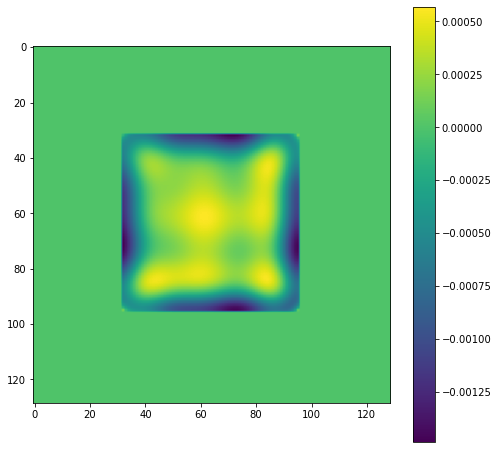

In [9]:
plt.figure(figsize = (8,8))
plt.imshow(rho)
plt.colorbar()
plt.show()

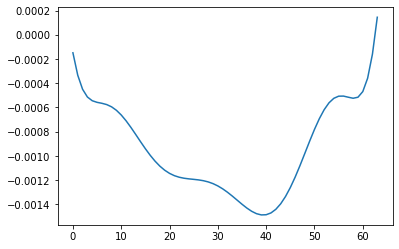

In [10]:
plt.plot(rho[n//4, n//4:3*n//4])
plt.show()

The CG residual is not decreasing, so something is wrong. 


It might be that there is an issue with my 2D convolution?